# Data Curation Notebook B - Study Selection

[Description]

Figures generated by this notebook:
- Figure 1A
- Figure 1B
- Figure 1D
- Figure 1E

Datasets generated by this notebooks:
- ??

## Set Up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import defaultdict
from tqdm import tqdm
import networkx as nx
from matplotlib_venn import venn2, venn3
from neteval import gene_mapper as gm
from neteval import query_ensembl as qe
from neteval import query_hgnc as qh
import obonet as obo
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wilcoxon

In [3]:
import matplotlib
import matplotlib.font_manager as fm
arial_font_path = '/cellar/users/snwright/Fonts/msfonts/Arial.TTF'
fm.fontManager.addfont(arial_font_path)
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams.update({'font.size': 7})
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['xtick.major.width'] = 0.4
plt.rcParams['ytick.major.width'] = 0.4
plt.rcParams['xtick.minor.width'] = 0.3
plt.rcParams['ytick.minor.width'] = 0.3
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.major.size'] = 3
plt.rcParams['ytick.major.size'] = 3
plt.rcParams['xtick.minor.size'] = 2
plt.rcParams['ytick.minor.size'] = 2
plt.rcParams['xtick.major.pad'] = 1
plt.rcParams['ytick.major.pad'] = 1
plt.rcParams['axes.labelpad'] = 1
plt.rcParams['patch.linewidth'] = 0.25
blue='#6ec1e0'
green='#5fad56'

In [4]:
datadir='/cellar/users/snwright/Data/RareCommon/'
outdir='/cellar/users/snwright/Data/Transfer/RVC/'
figdir='/cellar/users/snwright/Data/Transfer/RVC/figures/FIGURE1/'

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [6]:
pc_nodes = pd.read_csv(os.path.join(datadir, 'inputs', 'pcnet2_0_nodes.txt' ), sep='\t', header=None, names=['Entrez', 'degree']).Entrez.values

## Load Data

### GWAS Catalog

In [7]:
gwas_genes = pd.read_csv(os.path.join(datadir, 'GWASCatalog', 'gwas_catalog_Jan29_2025.txt.final'), sep='\t', index_col=0)
# filter to PCNet2.0 nodes
gwas_genes = gwas_genes[gwas_genes.Entrez.isin(pc_nodes)]
gwas_genes.shape

(327974, 16)

In [8]:
study_info = pd.read_csv(os.path.join(datadir,'GWASCatalog', 'cleaned_gwas-catalog-v1.0.3.1-studies-r2025-03-26.tsv'), sep="\t")
study_info = study_info.dropna(subset='TRAIT_CODE_CLEAN')
study_info['TRAIT_CODE_CLEAN'] = study_info['TRAIT_CODE_CLEAN'].apply(lambda z: z.split('/')[-1].replace(':', '_'))

In [9]:
import re
def extract_sample_size(s):
    if isinstance(s, str):
        # Find all occurrences of numbers which may include commas.
        matches = re.findall(r'\d[\d,]*', s)
        # Remove commas and convert each match to an integer, then sum them up.
        return sum(int(num.replace(',', '')) for num in matches)
    else:
        return np.nan

In [10]:
study_info['N'] = study_info['INITIAL SAMPLE SIZE'].apply(lambda x: extract_sample_size(x))

In [11]:
# merge the gene and study information
gwas_genes = gwas_genes.drop(columns=['TRAIT_CODE']).merge(study_info.drop(columns=['ASSOCIATION COUNT', 'SUMMARY STATS LOCATION']), 
                      on=['STUDY ACCESSION', "DISEASE/TRAIT", 'INITIAL SAMPLE SIZE','MAPPED_TRAIT', 'MAPPED_TRAIT_URI'],
                                             how='left')

In [12]:
# check that number of entries is unchanged
gwas_genes.shape

(327974, 38)

In [13]:
geneCounts = gwas_genes.groupby(['DISEASE/TRAIT', 'STUDY ACCESSION', 'TRAIT_CODE_CLEAN']).MAPPED_GENE.nunique().reset_index()
study_info = study_info.merge(geneCounts, on=['DISEASE/TRAIT', 'STUDY ACCESSION', 'TRAIT_CODE_CLEAN'], how='left')
study_info = study_info[study_info.MAPPED_GENE >= 3]

In [14]:
print('initial number of GWAS:', study_info.shape[0])
cv_start = study_info.TRAIT_CODE_CLEAN.nunique()
print('initial number of traits with GWAS:', cv_start)

initial number of GWAS: 7583
initial number of traits with GWAS: 2339


### RAVAR

In [15]:
ravar_genes = pd.read_csv(os.path.join(datadir,'RAVAR' ,'gene_fulltable_06112024.txt.entrez'),sep='\t', low_memory=False,
                            usecols=['Gene Symbol', 'Ensembl ID', 'Gene Type', 'CHR', 'Location', 'Reported Trait', 'Trait Label', 
                                     'Trait Ontology id', 'EFO synonym', 'P-value', 'PMID', 'TRAIT_CODE', 'Entrez'])
ravar_genes = ravar_genes[ravar_genes.Entrez.isin(pc_nodes)]
#replace '−' with '-'
#ravar_genes['P-value'] = ravar_genes['P-value'].apply(lambda x: float(x.replace('−','-')) if type(x) == str else float(x))
#ravar_genes['TRAIT_CODE'] = ravar_genes['Trait Ontology id'].apply(lambda x: x.replace(":", "_") if type(x) == str else x)

In [16]:
# remove any with 'Exclude' annotation
rv_study_info = pd.read_csv(os.path.join(datadir,'RAVAR', 'rv_study_info_cleaned_with_manual_mapped_Mar28.tsv'), sep='\t', index_col=0)
rv_study_info = rv_study_info[(~rv_study_info.COHORT.isin(['Exclude', 'Exlcude', 'Exlclude', 'Review'])) & (rv_study_info['Classification']!='Exclude')]

In [17]:
ravar_genes.shape

(75799, 13)

In [18]:
print(ravar_genes.shape)
ravar_genes = ravar_genes.merge(rv_study_info.loc[:, ('Reported Trait', 'PMID', 'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN')], 
                                on=['Reported Trait', 'PMID'], how='inner')
print(ravar_genes.shape)
study_counts = ravar_genes.groupby(['Reported Trait', 'PMID']).Entrez.nunique().reset_index()
study_counts = study_counts.rename(columns={'Entrez': 'GeneCount'})

(75799, 13)
(62020, 15)


In [19]:
print(ravar_genes.shape)
ravar_genes = ravar_genes.merge(study_counts[study_counts.GeneCount >= 3], on=['Reported Trait', 'PMID'])
rv_study_info = rv_study_info.merge(study_counts, on = ['Reported Trait', 'PMID'])
print(ravar_genes.shape)

(62020, 15)
(60374, 16)


In [20]:
rv_study_info = rv_study_info[rv_study_info.GeneCount>= 3]
rv_start= rv_study_info['TRAIT_CODE_CLEAN'].nunique()
print('initial number of RV studies:', rv_study_info.shape[0])
print('initial number of traits with RV studies:',rv_start)

initial number of RV studies: 2207
initial number of traits with RV studies: 1121


## Trait Embeddings

In [21]:
# identify and expand acronyms
import re
def extract_acronyms(strings):
    """
    Extract acronyms from a list of strings.
    Acronyms are identified as words that consist entirely of uppercase letters.
    
    Args:
        strings (list of str): List of strings to search for acronyms.
    
    Returns:
        set: A set of unique acronyms found across the provided strings.
    """
    # Using \b[A-Z]{2,}\b to match words with 2 or more uppercase letters.
    # Adjust the {2,} if you also want to capture single-letter acronyms.
    acronym_pattern = re.compile(r'\b[A-Z]{2,}\b')
    acronyms = set()
    for text in strings:
        found = acronym_pattern.findall(text)
        acronyms.update(found)
    return acronyms

def replace_acronyms(text, acronym_dict):
    """
    Replace acronyms in a string with their expansions followed by the original acronym in parentheses.
    
    Args:
        text (str): The input string containing acronyms.
        acronym_dict (dict): A dictionary where keys are acronyms (str) and values are the expansions (str).
    
    Returns:
        str: The text with acronyms replaced by their expansion and the original acronym in parentheses.
    """
    # This regex matches words consisting of at least two uppercase letters.
    acronym_pattern = re.compile(r'[A-Z]{2,}')
    
    def replacer(match):
        word = match.group(0)
        if word in acronym_dict:
            # Return the expansion with the original acronym in parentheses.
            return f"{acronym_dict[word]} ({word})"
        else:
            return word
    
    return acronym_pattern.sub(replacer, text)

In [22]:
common_acronyms = {
    'LDL': 'low density lipoprotein',
    'HDL': 'high density lipoprotein',
    'BMI': 'body mass index',
    'VLDL': 'very low density lipoprotein',
    'IL': 'interleukin',
    'IDL': 'intermediate density lipoprotein',
    'FVC': 'forced vital capacity',
    'FEV': 'forced expiratory volume',
    'COVID': 'coronavirus',
    'HIV': 'human immunodeficiency virus',
    'SARS': 'severe acute respiratory syndrome',
    'APOE': 'apolipoprotein E',
    'APOB': 'apolipoprotein B',
    'APOA': 'apolipoprotein A',
}

acronym_expansions = {
    'ldl': 'low density lipoprotein',
    'hdl': 'high density lipoprotein',
    "FAW3": 'omega-3 polyunsaturated fatty acid',
    "FAW6": 'omega-6 polyunsaturated fatty acid',
    "FEC": "Forced Expiratory volume",
    "FEV": "Forced Expiratory volume",
    "HIV": "Human Immunodeficiency Virus",
    "IV": "4",
    "LDH": "lumbar disc herniation",
    "NHDL": 'non High density ipoprotein',
    "NSAID": 'nonsteroidal anti inflammatory drug',
    "ACACE": "Acetoacetate",                                
    "ACE": "Acetate",             
    "ALA": "Alanine",                       # An essential omega-3 fatty acid
    "ALB": "Albumin",                                    # Main blood protein
    "APOB": "Apolipoprotein B",                           # Major protein of LDL particles
    "APOC": "Apolipoprotein C",                           # Protein component of several lipoproteins
    "BMI": "Body Mass Index",                            # Anthropometric measure
    "BP": "Blood Pressure",                              # Cardiovascular measure
    "CHOLA": "Cholesterol",                              # Cholesterol level (a general measure)
    "CIT": "Citrate",                                    # Metabolite in the citric acid cycle
    "CRP": "C-Reactive Protein",                         # Inflammatory marker
    "DHA": "Docosahexaenoic Acid",                       # An omega-3 fatty acid important in brain health
    "DISTRIB": "Distribution",                           # Typically referring to a dispersion measure (e.g. cell size distribution)
    "EGFR": "Estimated Glomerular Filtration Rate",      # Kidney function measure
    "FRAC": "Fraction",                                  # Proportion or fractional measure of a component
    "FVC": "Forced Vital Capacity",                      # Lung function measure
    "GLN": "Glutamine",                                  # An amino acid
    "GLOL": "Glycerol",                             # Summary measure across lipid traits
    "GLY": "Glycine",                                    # An amino acid
    "GP": "Glycoproteins",                        # Inflammatory biomarker (often abbreviated GlycA)
    "HDL": "High Density Lipoprotein",                   # ‘Good’ cholesterol carrier
    "HDLC": "High Density Lipoprotein Cholesterol",      # Cholesterol within HDL particles
    "HEEL": "Heel Bone Mineral Density",                 # Bone density measurement (often via heel ultrasound)
    "HEIGHT": "Height",                                  # Stature
    "HIS": "Histidine",                                  # An essential amino acid
    "IDL": "Intermediate Density Lipoprotein",           # A lipoprotein class between VLDL and LDL
    "IGF": "Insulin like Growth Factor",                 # A hormone linked to growth processes
    "III": "Type III",                                  # Often denotes a subclass or type (context dependent)
    "INS": "Insulin",                                    # Hormone regulating blood sugar
    "LA": "Linoleic Acid",                               # An essential omega-6 fatty acid
    "LDL": "Low Density Lipoprotein",                    # ‘Bad’ cholesterol carrier
    "LDLC": "Low Density Lipoprotein Cholesterol",       # Cholesterol within LDL particles
    "LIGHT": "Light Scatter",                            # Measure from flow cytometry (reflects cell granularity)
    "MUFA": "Monounsaturated Fatty Acids",               # Type of dietary fat
    "PC": "Phosphatidylcholine",                         # A major phospholipid in cell membranes
    "PHE": "Phenylalanine",                              # An amino acid
    "PUFA": "Polyunsaturated Fatty Acids",              # Type of dietary fat
    "PYR": "Pyruvate",                                   # Key metabolite in energy metabolism
    "RBC": "Red Blood Cell Count",                       # Red blood cells count
    "SCZD": "Schizophrenia",                             # Psychiatric disorder trait
    "SHBG": "Sex Hormone-Binding Globulin",              # Protein that binds sex hormones
    "SPHERED": "Spherical Diameter",                     # Typically refers to the diameter of lipoprotein particles
    "SYST": "Systolic Blood Pressure",                   # Upper value in blood pressure measurement
    "TOTCHO": "Total Cholines",                       # Overall cholesterol level
    "TOTCHOL": "Total Cholesterol",                      # Overall cholesterol level
    "TOTPG": "Total Phosphoglycerides",                  # Sum of phosphoglyceride species
    "TSCORE": "T-Score",                                 # Bone density T-score
    "TYR": "Tyrosine",                                   # An amino acid
    "VAL": "Valine",                                     # An amino acid
    "VIT": "Vitamin (unspecified)",                     # Vitamin level (exact vitamin may vary by context)
    "VLDL": "Very Low Density Lipoprotein",              # A lipoprotein class rich in triglycerides
    "VLDLPL": "Very low density lipoprotein Phospholipids",                      # Phospholipid content in VLDL particles
    "VLDLTG": "Very low density lipoprotein Triglycerides",                      # Triglyceride content in VLDL particles
    "VOL": "Volume",                                     # A generic volume measure (often of cells or particles)
    "Whr": "Waist Hip Ratio",
    "whr": "Waist Hip Ratio",
    "WHR": "Waist Hip Ratio",                            # Measure of body fat distribution
    "XL": "Extra Large",                                # Refers to an extra-large size category (e.g., lipoprotein particles)
    "XS": "Extra Small"                                 # Refers to an extra-small size category (e.g., lipoprotein particles)
}

all_acronyms = {**common_acronyms, **acronym_expansions}

### GWAS Catalog

In [23]:
study_info['MappedCleanExp'] = study_info['MAPPED_TRAIT_CLEAN'].apply(lambda x: replace_acronyms(x, all_acronyms))

In [25]:
trait = model.encode(study_info['TraitExp'].values, batch_size=32)
mapped = model.encode(study_info['MappedCleanExp'].values, batch_size=32)
cosines = cosine_similarity(trait, mapped)
study_info = study_info.assign(Cosine=[cosines[i,i] for i in range(len(trait))])
study_info = study_info.drop_duplicates()

### RAVAR

In [26]:
rv_study_info['MappedCleanExp'] = rv_study_info['MAPPED_TRAIT_CLEAN'].apply(lambda x: replace_acronyms(x, acronym_expansions))

In [27]:
reported = model.encode(rv_study_info['TraitExp'].values, batch_size=32)
labeled = model.encode(rv_study_info['MappedCleanExp'].values, batch_size=32)
cosines = cosine_similarity(reported, labeled)
rv_study_info = rv_study_info.assign(Cosine=[cosines[i,i] for i in range(len(reported))])
rv_study_info.COHORT.unique()

array(['SpiroMeta,CHARGE', 'WTCCC', 'TOPMed', 'Mixed', 'UKB', 'ADNI',
       'MyCode', 'WHI', 'ARIC', 'Meta', 'Finnish', 'COPDGene',
       'SCOOP,INTERVAL', 'Study36038634', 'KARE', 'Psoriasis',
       'Faroe Islands', 'GAW19', 'PDAY', 'SCZD', 'NHLBI-ESP,CHARGE',
       'AGP', 'HyperGEN', 'GIANT', 'Nevada', 'Study30140000', 'FHS',
       'Qatar', 'NCRAD', 'SLSJ'], dtype=object)

## Study Selection

### GWAS Catalog

In [28]:
def select_top_gwas_study(gwas_data, trait, study_info, keep_studies, exclude=['UKB', 'UKBB']):
    study_info['StudyTrait'] = study_info['STUDY ACCESSION'] + '_' + study_info['TRAIT_CODE_CLEAN']
    study_subset = study_info[study_info['STUDY ACCESSION'].isin(gwas_data[(gwas_data.TRAIT_CODE_CLEAN==trait) & (gwas_data['STUDY ACCESSION'].isin(keep_studies))]['STUDY ACCESSION'])]
    study_subset = study_subset.dropna(subset=['N'])
    #print(len(study_subset))
    
    if len(study_subset) > 1:
        study_subset = prioritize_by_cosine(study_subset, th=0.8)
        if len(study_subset) > 1:
            study_subset = prioritize_by_cohort(study_subset, exclude=exclude)
            if len(study_subset) > 1:
                study_subset = prioritize_by_n(study_subset)
                if len(study_subset) > 1:
                    study_subset = prioritize_by_sumstats(study_subset)
                    if len(study_subset) > 1:
                        study_subset = prioritize_by_cohort(study_subset)
                        if len(study_subset) > 1:
                            return select_top_n(study_subset)
                        else:
                            return study_subset['STUDY ACCESSION'].values[0]
                    else:
                        return study_subset['STUDY ACCESSION'].values[0]
                else:
                    return study_subset['STUDY ACCESSION'].values[0]
            else:
                return study_subset['STUDY ACCESSION'].values[0]
        else:
            return study_subset['STUDY ACCESSION'].values[0]
    elif len(study_subset) == 0:
        #print('No studies with N information')
        return np.nan
    else:
        return study_subset['STUDY ACCESSION'].values[0]


def prioritize_by_cosine(study_subset, th=0.8):
    while th > -0.1:
        high_cosine = study_subset[study_subset.Cosine>th]
        if len(high_cosine) >= 1:
            non_found = False
            return high_cosine
        else:
            th -= 0.1
    return high_cosine
    
    
def prioritize_by_sumstats(study_subset):
    with_sumstats = study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]
    if len(with_sumstats) == 0:
        return study_subset
    else:
        return with_sumstats

def prioritize_by_n(study_subset):
    high_n = study_subset[study_subset.N > 100000]
    if len(high_n) == 0:
        high_n = study_subset[study_subset.N > 50000]
        if len(high_n) == 0:
            return study_subset
        else:
            return high_n
    else:
        return high_n
    

def prioritize_by_cohort(study_subset, exclude=[]):
    if len(exclude) > 0:
        excluded = study_subset[~study_subset.COHORT.isin(exclude)]
        if len(excluded) > 0:
            return excluded
        else:
            return study_subset
    else:
        with_cohort = study_subset[~study_subset.COHORT.isna()]
        if len(with_cohort) == 0:
            return study_subset
        else:
            return with_cohort
        

def select_top_n(study_subset):
    return study_subset.sort_values('N', ascending=False)['STUDY ACCESSION'].values[0]


def prioritize_gwas_studies(gwas_data, trait, keep_studies, study_info, n=5, verbose=True):
    study_info['StudyTrait'] = study_info['STUDY ACCESSION'] + '_' + study_info['TRAIT_CODE']
    study_subset = study_info[study_info['STUDY ACCESSION'].isin(gwas_data[gwas_data.TRAIT_CODE==trait]['STUDY ACCESSION'])]
    
    study_subset = study_subset[study_subset['StudyTrait'].isin(keep_studies)]
    initial_count = len(study_subset)
    study_subset = study_subset.dropna(subset=['N'])

    out_studies = []
    if len(study_subset) > n:
        # remove those with background traits
        study_subset = study_subset[study_subset['MAPPED BACKGROUND TRAIT URI'].isna()]
        if len(study_subset) > n:
            #priortize those with summary stats available
            if len(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]) > n:
                study_subset = study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()]
            else:
                out_studies += list(study_subset[~study_subset['SUMMARY STATS LOCATION'].isna()].drop_duplicates(subset=['COHORTID'])['STUDY ACCESSION'].values)
                n -= len(out_studies)
                study_subset = study_subset[study_subset['SUMMARY STATS LOCATION'].isna()]
            # then sort by population size.
            study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
            # then select by cohort
            has_cohort = study_subset[~study_subset.COHORT.isna()]
            keep_cohort = has_cohort.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
            if len(keep_cohort) >= n:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values[0:n])
            else:
                out_studies += list(keep_cohort['STUDY ACCESSION'].values)
                n = n - len(keep_cohort)
                out_studies += list(study_subset[study_subset.COHORT.isna()]['STUDY ACCESSION'].values[0:n])
        else:
            out_studies += list(study_subset['STUDY ACCESSION'].values)
    else:
        study_subset = study_subset.sort_values(['N', 'ASSOCIATION COUNT'], ascending=False)
        keep_cohort = study_subset.drop_duplicates(subset='COHORTID', keep='first').drop_duplicates(subset='DATE ADDED TO CATALOG')
        out_studies += list(keep_cohort['STUDY ACCESSION'].values)
    if verbose:
        print(trait, initial_count, len(out_studies))
    return out_studies



In [29]:
multi_select_cv = {}
for t in tqdm(study_info['TRAIT_CODE_CLEAN'].unique()):
    t.replace(':', '_')
    
    multi_select_cv[t] = select_top_gwas_study(gwas_genes, t, study_info, exclude=[],
                                               keep_studies=study_info['STUDY ACCESSION'].values)

100%|██████████| 2339/2339 [01:12<00:00, 32.41it/s]


### RAVAR

In [30]:
def prioritize_rv_studies(ravar_genes, trait, study_info, keep_studies, cosine_th=0.8, exclude=['UKB']):
    study_subset = study_info[study_info.PMID.isin(ravar_genes[(ravar_genes.TRAIT_CODE_CLEAN==trait) & (ravar_genes.PMID.isin(keep_studies))].PMID.unique())]
    # filter
    study_subset = study_subset[~study_subset.isin(['Exclude', 'Review'])]
    study_subset = study_subset.sort_values('Cosine', ascending=False)
    if len(study_subset) > 1:
        cosine = prioritize_by_cosine(study_subset, th=0.8)
        cosine = prioritize_by_cohort(cosine, exclude=exclude)
        if len(cosine) == 1:
            return cosine.PMID.values[0]
        elif len(cosine) > 1:
            # return the best match/largest
            return cosine.sort_values(by=['Cosine','N' ], ascending=False).PMID.values[0]
        else:
            # none with 
            return np.nan
    elif len(study_subset) == 0: 
        return np.nan
    else:
        return study_subset.PMID.values[0]

def prioritize_by_cohort(study_subset, exclude=['UKB']):
    if len(exclude) == 0:
        return study_subset
    excluded = study_subset[~study_subset.COHORT.isin(exclude)]
    if len(excluded) > 0:
        return excluded
    else:
        return study_subset
    

def prioritize_by_cosine(study_subset, th=0.8):
    while th > -0.1:
        high_cosine = study_subset[study_subset.Cosine>th]
        if len(high_cosine) >= 1:
            non_found = False
            return high_cosine
        else:
            th -= 0.1
    return high_cosine

In [31]:
multi_select_rv = {}
for t in rv_study_info['TRAIT_CODE_CLEAN'].unique():
    t = t.replace(':', '_')
    multi_select_rv[t] = prioritize_rv_studies(ravar_genes, t, rv_study_info, exclude=[],
                                                      keep_studies=rv_study_info.PMID.values)

## Identification of shared traits

In [32]:
shared_studies = list(set(multi_select_cv.keys()).intersection(multi_select_rv.keys()))
shared_rv = pd.DataFrame({'TRAIT_CODE_CLEAN':shared_studies, 'PMID': [multi_select_rv[x] for x in shared_studies]}, index=shared_studies)
shared_rv = shared_rv.dropna()
shared_rv['PMID'] = shared_rv.PMID.astype(int)
rv_study_info['PMID'] = rv_study_info.PMID.astype(int)

Collect study information for matched traits

In [33]:
shared_rv = rv_study_info.merge(shared_rv, on=['PMID', 'TRAIT_CODE_CLEAN'], 
                    how='inner').drop_duplicates().sort_values(by='Cosine', ascending=False)
shared_rv = shared_rv.drop_duplicates(subset=['PMID', 'TRAIT_CODE_CLEAN'])

In [34]:
shared_cv = pd.DataFrame({'STUDY ACCESSION': multi_select_cv}).reset_index().rename(columns={'index':'TRAIT_CODE_CLEAN'}).dropna()
shared_cv = shared_cv[shared_cv.TRAIT_CODE_CLEAN.isin(shared_studies)]
shared_cv = study_info.merge(shared_cv, on=['STUDY ACCESSION', 'TRAIT_CODE_CLEAN'], 
                             how='inner').drop_duplicates().sort_values(by='Cosine', ascending=False)
#shared_cv.to_csv(os.path.join(datadir, 'GWASCatalog', 'gwascat_ravar_study_Mar28.txt'), sep='\t', index=False)

In [35]:
a = shared_cv.loc[:, ('DISEASE/TRAIT', 'STUDY ACCESSION', 'COHORT', 'TRAIT_CODE_CLEAN', 'MAPPED_TRAIT_CLEAN', 'N', 'Cosine', 'TraitExp', 'MappedCleanExp', 'PUBMED ID')]
b = shared_rv.loc[:, ('Reported Trait', 'Trait Label', 'PMID', 'COHORT', 'N', 'Classification', 'Cosine', 'MAPPED_TRAIT_CLEAN', 'TRAIT_CODE_CLEAN','TraitExp', 'MappedCleanExp' )]
shared_df = a.merge(b, on=['TRAIT_CODE_CLEAN'], how='inner', suffixes=['_C', '_R'])
shared_cv_trait = model.encode(shared_df['TraitExp_C'], batch_size=32)
shared_rv_trait = model.encode(shared_df['TraitExp_R'], batch_size=32)
cosines = cosine_similarity(shared_cv_trait, shared_rv_trait)
shared_df = shared_df.assign(CosineRC=[cosines[i,i] for i in range(len(shared_cv_trait))])
#shared_df.loc[:, ('Reported Trait', 'DISEASE/TRAIT','MAPPED_TRAIT_CLEAN_C', 'MAPPED_TRAIT_CLEAN_R', 'Cosine_R', 'Cosine_C', 
#                  'CosineRC')].to_csv('/cellar/users/snwright/Data/Transfer/RVC/data/check_trait_pairs.txt', sep='\t')


In [36]:
shared_df.shape

(394, 21)

In [37]:
raise NotImplementedError('Manual curation needed')

NotImplementedError: Manual curation needed

In [40]:
clean_shared_df = pd.read_csv('/cellar/users/snwright/Data/Transfer/RVC/data/RV Study Info - Shared Traits6.tsv', sep='\t', index_col=0)
final_shared_df = shared_df.merge(clean_shared_df.loc[clean_shared_df.Keep==1, ('Reported Trait', 'DISEASE/TRAIT', 'Domain', 'trait_type')], 
                       on=['Reported Trait', 'DISEASE/TRAIT'], how='inner', suffixes=['', 'Final'])
assert len(final_shared_df) == clean_shared_df.Keep.sum(), 'Manual file does not match'
final_shared_df['StudyC'] = final_shared_df['STUDY ACCESSION'] + '_' + final_shared_df['TRAIT_CODE_CLEAN']
final_shared_df['StudyR'] = final_shared_df['PMID'].astype(str) + '_' + final_shared_df['TRAIT_CODE_CLEAN']
#final_shared_df.drop_duplicates(subset='TRAIT_CODE_CLEAN').to_csv('/cellar/users/snwright/Data/RareCommon/inputs/March_2025/shared_traits_df_Mar28.tsv', sep='\t', index=False)

In [41]:
final_shared_df.shape

(373, 25)

## Create Input Files

In [ ]:
inputdir = '/cellar/users/snwright/Data/RareCommon/inputs/March_2025'
with open(os.path.join(inputdir, 'common.traitlist'), 'w') as f:
    f.writelines('\n'.join(final_shared_df.StudyC.values)+'\n')
with open(os.path.join(inputdir, 'rare.traitlist'), 'w') as f:
    f.writelines('\n'.join(final_shared_df.StudyR.values)+'\n')

In [ ]:
c_size= []
for i, t in tqdm(enumerate(final_shared_df.TRAIT_CODE_CLEAN.values)):
    accession = final_shared_df.iloc[i]['STUDY ACCESSION']
    trait = final_shared_df.iloc[i]['DISEASE/TRAIT']
    study_genes = gwas_genes[(gwas_genes.TRAIT_CODE_CLEAN==t) & (gwas_genes['STUDY ACCESSION']==accession) & (gwas_genes['DISEASE/TRAIT']==trait)]
    study_genes = study_genes.sort_values('logp', ascending=False)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    study_out = study_genes.loc[:, ('Entrez', 'MAPPED_GENE', 'P-VALUE', 'OR or BETA' )]
    study_out.columns = ['Entrez', 'Gene Symbol', 'P-value', 'Beta']
    c_size.append(len(study_out))
    #study_out.to_csv(os.path.join(inputdir, accession+'_'+t+'_CV.txt'), sep='\t', index=False)

In [ ]:
r_size=[]
for i, t in tqdm(enumerate(final_shared_df.TRAIT_CODE_CLEAN.values)):
    pmid = final_shared_df.iloc[i]['PMID']
    trait = final_shared_df.iloc[i]['Reported Trait']
    study_genes = ravar_genes[(ravar_genes.TRAIT_CODE_CLEAN==t) & (ravar_genes['PMID']==pmid) & (ravar_genes['Reported Trait']==trait)]
    study_genes = study_genes.sort_values('P-value', ascending=True)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    study_out = study_genes.loc[:, ('Entrez', 'Gene Symbol','Ensembl ID',  'P-value')]
    r_size.append(len(study_out))
    #study_out.to_csv(os.path.join(inputdir, str(int(pmid))+'_'+t+'_RV.txt'), sep='\t', index=False)

## Identificaiton of trait replicates

In [188]:
# remove already used studies
def identify_trait_repeats_cv(trait, study_info, exclude_study_info=('pmid', 'study acc', 'dis/t'), n=4, cosine_min=0.7):
    trait_info = study_info[study_info.TRAIT_CODE_CLEAN==trait]
    # identify the info of the already selected study:
    cohort = trait_info[(trait_info['STUDY ACCESSION'] == exclude_study_info[1]) &
                       (trait_info['DISEASE/TRAIT'] == exclude_study_info[2]) &
                       (trait_info['PUBMED ID'] == exclude_study_info[0])].COHORT.values[0]
    # drop based on cosine similarities
    trait_info = trait_info[trait_info.Cosine >= cosine_min]
    # first drop by PMID
    trait_info = trait_info[~trait_info['PUBMED ID'].isin([exclude_study_info[0]])]
    
    # now prioritize remaining studies
    if len(trait_info) == 0:
        return np.nan
    elif len(trait_info) <= n:
        return [x for x in zip(trait_info['STUDY ACCESSION'].values, trait_info['DISEASE/TRAIT'].values)]
    else:
        # still too many studies
        remove_cohort = trait_info[trait_info.COHORT!=cohort].sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='COHORT')
        out_studies = []
        out_studies += [x for x in zip(remove_cohort['STUDY ACCESSION'].values, remove_cohort['DISEASE/TRAIT'].values)]
        if len(out_studies) == n:
            return out_studies
        elif len(out_studies) >= n:
            return out_studies[0:n]
        else:
            while len(out_studies) < n:
            
                remaining_n = n - len(out_studies)
                remaining_studies = trait_info[~trait_info['STUDY ACCESSION'].isin([x[0] for x in out_studies])].sort_values(by=['Cosine', 'N'], ascending=False)
                if len(remaining_studies.drop_duplicates(subset='COHORT')) > remaining_n:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['STUDY ACCESSION'].values[0:remaining_n],
                                                  remaining_studies.drop_duplicates(subset='COHORT')['DISEASE/TRAIT'].values[0:remaining_n])]
                    return out_studies
                else:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['STUDY ACCESSION'].values,
                                                  remaining_studies.drop_duplicates(subset='COHORT')['DISEASE/TRAIT'].values)]
            return out_studies
                
    
    

In [163]:
trait_info = identify_trait_repeats_cv( t, study_info, exclude_study_info=(pmid, acc, dis),n=4)
exclude_study_info=(pmid, acc, dis)
cohort = trait_info[(trait_info['STUDY ACCESSION'] == exclude_study_info[1]) &
                   (trait_info['DISEASE/TRAIT'] == exclude_study_info[2]) &
                   (trait_info['PUBMED ID'] == exclude_study_info[0])].COHORT.values[0]
trait_info = trait_info[~trait_info['PUBMED ID'].isin([pmid])]

In [165]:
trait_info[trait_info.COHORT!=cohort].sort_values(by=['N', 'Cosine'], ascending=False)

,DATE ADDED TO CATALOG,PUBMED ID,FIRST AUTHOR,DATE,JOURNAL,LINK,STUDY,DISEASE/TRAIT,INITIAL SAMPLE SIZE,REPLICATION SAMPLE SIZE,...,GXE,TraitExp,MappedExp,MAPPED_TRAIT_CLEAN,TRAIT_CODE_CLEAN,N,MAPPED_GENE,MappedCleanExp,Cosine,StudyTrait
2807,2020-03-30,31959851,Olafsdottir TA,2020-01-20,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/31959851,Eighty-eight variants highlight the role of T ...,Asthma,"16,247 European ancestry cases, 346,486 Europe...",NaN,...,no,Asthma,asthma,asthma,MONDO_0004979,771388.0,42.0,asthma,1.000000,GCST009798_MONDO_0004979
15390,2021-12-14,34594039,Sakaue S,2021-09-30,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/34594039,A cross-population atlas of genetic associatio...,Asthma,"38,369 European ancestry cases, 411,131 Europe...",NaN,...,no,Asthma,asthma,asthma,MONDO_0004979,625448.0,32.0,asthma,1.000000,GCST90018795_MONDO_0004979
6309,2020-06-04,32296059,Han Y,2020-04-15,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/32296059,Genome-wide analysis highlights contribution o...,Asthma,"84,492 European ancestry cases, 2,149 African ...",NR,...,no,Asthma,asthma,asthma,MONDO_0004979,536345.0,98.0,asthma,1.000000,GCST010043_MONDO_0004979
6951,2020-04-17,31669095,Zhu Z,2019-10-24,J Allergy Clin Immunol,www.ncbi.nlm.nih.gov/pubmed/31669095,Shared Genetic and Experimental Links between ...,Nonatopic asthma,"28,862 European ancestry cases, 422,048 Europe...",NaN,...,no,Nonatopic asthma,asthma,asthma,MONDO_0004979,450910.0,42.0,asthma,0.784191,GCST009845_MONDO_0004979
9011,2021-06-23,34103634,Valette K,2021-06-08,Commun Biol,www.ncbi.nlm.nih.gov/pubmed/34103634,Prioritization of candidate causal genes for a...,Asthma,"56,167 White-British ancestry cases, 352,255 W...",NaN,...,no,Asthma,asthma,asthma,MONDO_0004979,408422.0,37.0,asthma,1.000000,GCST90014325_MONDO_0004979
4605,2019-10-25,31619474,Zhu Z,2019-10-17,Eur Respir J,www.ncbi.nlm.nih.gov/pubmed/31619474,Shared Genetics of Asthma and Mental Health Di...,Asthma,"46,802 European ancestry cases, 347,481 Europe...","23,948 European and unknown ancestry cases, 11...",...,no,Asthma,asthma,asthma,MONDO_0004979,394283.0,47.0,asthma,1.000000,GCST008916_MONDO_0004979
2726,2019-05-14,30929738,Ferreira MAR,2019-03-28,Am J Hum Genet,www.ncbi.nlm.nih.gov/pubmed/30929738,Genetic Architectures of Childhood- and Adult-...,Asthma,"40,544 European ancestry cases, 300,671 Europe...",NaN,...,no,Asthma,asthma,asthma,MONDO_0004979,341215.0,59.0,asthma,1.000000,GCST007798_MONDO_0004979
6310,2020-06-04,32296059,Han Y,2020-04-15,Nat Commun,www.ncbi.nlm.nih.gov/pubmed/32296059,Genome-wide analysis highlights contribution o...,Asthma,"64,538 European ancestry cases, 239,321 Europe...",NR,...,no,Asthma,asthma,asthma,MONDO_0004979,303859.0,82.0,asthma,1.000000,GCST010042_MONDO_0004979
7405,2020-03-02,31361310,Johansson A,2019-07-30,Hum Mol Genet,www.ncbi.nlm.nih.gov/pubmed/31361310,Genome-wide association analysis of 350 000 Ca...,Asthma,"41,926 European ancestry cases, 239,773 Europe...","10,365 cases, 16,100 controls",...,no,Asthma,asthma,asthma,MONDO_0004979,281699.0,41.0,asthma,1.000000,GCST009720_MONDO_0004979
6635,2021-02-26,32514122,Ishigaki K,2020-06-08,Nat Genet,www.ncbi.nlm.nih.gov/pubmed/32514122,Large-scale genome-wide association study in a...,Asthma,"8,216 Japanese ancestry cases, 201,592 Japanes...",NaN,...,no,Asthma,asthma,asthma,MONDO_0004979,209808.0,8.0,asthma,1.000000,GCST90013679_MONDO_0004979


In [203]:
drop_cv = ['GCST003987_MONDO_0004979', 'GCST012230_EFO_0007788', 'GCST009004_EFO_0004340']
cv_repeats = {}
for t in tqdm(final_shared_df['TRAIT_CODE_CLEAN'].unique()):

    t.replace(':', '_')
    pmid = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('PUBMED ID')].values[0]
    acc = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('STUDY ACCESSION')].values[0]
    dis = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('DISEASE/TRAIT')].values[0]
    cv_repeats[t] = identify_trait_repeats_cv( t, study_info[~study_info.StudyTrait.isin(drop_cv)], exclude_study_info=(pmid, acc, dis),n=4)

100%|██████████| 373/373 [00:02<00:00, 174.90it/s]


In [141]:
    pmid = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('PUBMED ID')].values[0]
    acc = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('STUDY ACCESSION')].values[0]
    dis = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('DISEASE/TRAIT')].values[0]

GCST90399687 **GCST009798** GCST90018795 GCST90014325 GCST90013679

In [147]:
study_info[study_info['STUDY ACCESSION'].isin(['GCST009798', 'GCST003987'])].T

,2807,3627
DATE ADDED TO CATALOG,2020-03-30,2017-05-11
PUBMED ID,31959851,27182965
FIRST AUTHOR,Olafsdottir TA,Pickrell JK
DATE,2020-01-20,2016-05-16
JOURNAL,Nat Commun,Nat Genet
LINK,www.ncbi.nlm.nih.gov/pubmed/31959851,www.ncbi.nlm.nih.gov/pubmed/27182965
STUDY,Eighty-eight variants highlight the role of T ...,Detection and interpretation of shared genetic...
DISEASE/TRAIT,Asthma,Asthma
INITIAL SAMPLE SIZE,"16,247 European ancestry cases, 346,486 Europe...","28,399 European ancestry cases, 128,843 Europe..."
REPLICATION SAMPLE SIZE,NaN,NaN


In [186]:
# remove already used studies
def identify_trait_repeats_rv(trait, study_info, exclude_study_info=('pmid', 'dis/t'), n=4, cosine_min=0.7):
    trait_info = study_info[study_info.TRAIT_CODE_CLEAN==trait]
    # identify the info of the already selected study:
    cohort = trait_info[(trait_info['Reported Trait'] == exclude_study_info[1]) &
                       (trait_info['PMID'] == exclude_study_info[0])].COHORT.values[0]
    # drop based on cosine similarities
    trait_info = trait_info[trait_info.Cosine >= cosine_min]
    
    # first drop by PMID
    trait_info = trait_info[~trait_info['PMID'].isin([exclude_study_info[0]])]
    
    # now prioritize remaining studies
    if len(trait_info) == 0:
        return np.nan
    elif len(trait_info) <= n:
        out_info = trait_info.sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='PMID')
        return [x for x in zip(out_info['PMID'].values, out_info['Reported Trait'])]
    else:
        # still too many studies
        remove_cohort = trait_info[trait_info.COHORT!=cohort].sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='COHORT').drop_duplicates(subset='PMID')
        out_studies = []
        out_studies += [x for x in zip(remove_cohort['PMID'].values, remove_cohort['Reported Trait'])]
        if len(out_studies) == n:
            return out_studies
        elif len(out_studies) >= n:
            return out_studies[0:n]
        else:
            while len(out_studies) < n:
            
                remaining_n = n - len(out_studies)
                remaining_studies = trait_info[~trait_info['PMID'].isin([x[0] for x in out_studies])].sort_values(by=['Cosine', 'N'], ascending=False).drop_duplicates(subset='PMID')
                if len(remaining_studies) == 0:
                    return out_studies
                if len(remaining_studies.drop_duplicates(subset='COHORT')) > remaining_n:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['PMID'].values[0:remaining_n],
                                   remaining_studies.drop_duplicates(subset='COHORT')['Reported Trait'].values[0:remaining_n])]
                    return out_studies
                else:
                    out_studies += [x for x in zip(remaining_studies.drop_duplicates(subset='COHORT')['PMID'].values,
                                   remaining_studies.drop_duplicates(subset='COHORT')['Reported Trait'].values)]
            return out_studies
    
    

In [187]:
rv_repeats = {}
for t in tqdm(final_shared_df['TRAIT_CODE_CLEAN'].unique()):
    t.replace(':', '_')
    pmid = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('PMID')].values[0]
    dis = final_shared_df.loc[final_shared_df.TRAIT_CODE_CLEAN==t,('Reported Trait')].values[0]
    rv_repeats[t] = identify_trait_repeats_rv( t, rv_study_info, exclude_study_info=(pmid,dis),n=4)

100%|██████████| 373/373 [00:00<00:00, 497.24it/s]


### Create genesets

In [86]:
for i, t in tqdm(enumerate(cv_repeats.keys())):
    if isinstance(cv_repeats[t], list):
        for acc, dis in cv_repeats[t]:
            study_genes = gwas_genes[(gwas_genes.TRAIT_CODE_CLEAN==t) & 
                                     (gwas_genes['STUDY ACCESSION']==acc) & 
                                     (gwas_genes['DISEASE/TRAIT']==dis)]
            study_genes = study_genes.sort_values('P-VALUE', ascending=True)
            study_genes = study_genes.drop_duplicates(subset='Entrez')
            study_out = study_genes.loc[:, ('Entrez', 'MAPPED_GENE', 'P-VALUE', 'OR or BETA' )]
            study_out.columns = ['Entrez', 'Gene Symbol', 'P-value', 'Beta']
            study_out.to_csv(os.path.join(inputdir, acc+'_'+t+'_CV.txt'), sep='\t', index=False)

373it [00:33, 11.28it/s]


In [87]:
for i, t in tqdm(enumerate(rv_repeats.keys())):
    if isinstance(rv_repeats[t], list):
        for acc, dis in rv_repeats[t]:  
            study_genes = ravar_genes[(ravar_genes.TRAIT_CODE_CLEAN==t) & 
                                      (ravar_genes['PMID']==acc) & 
                                      (ravar_genes['Reported Trait']==dis)]

            study_genes = study_genes.sort_values('P-value', ascending=True)
            study_genes = study_genes.drop_duplicates(subset='Entrez')
            study_out = study_genes.loc[:, ('Entrez', 'Gene Symbol','Ensembl ID',  'P-value')]
            study_out.to_csv(os.path.join(inputdir, str(int(acc))+'_'+t+'_RV.txt'), sep='\t', index=False)

373it [00:01, 259.94it/s]


### Create repeat pairs, including originals

In [204]:
all_pairs = []
for trait in cv_repeats.keys():
    original_cv = multi_select_cv[trait]
    original_rv = multi_select_rv[trait]
    new_cv = cv_repeats[trait]
    new_rv = rv_repeats[trait]
    if isinstance(new_cv, list):
        all_cv = [original_cv] + [x[0] for x in new_cv]
    else:
        all_cv = [original_cv]
    if isinstance(new_rv, list):
        all_rv = [original_rv] + [x[0] for x in new_rv]
    else:
        all_rv = [original_rv]
    r_studies = []
    c_studies = []
    for studyC in all_cv:
        for studyR in all_rv:
            if (studyR != original_rv) or (studyC != original_cv):
                r_studies.append(studyR)
                c_studies.append(studyC)
    if len(c_studies) > 0:
        all_pairs.append(pd.DataFrame({'C':c_studies, 'R':r_studies, 'TRAIT_CODE_CLEAN':trait}))
        
repeat_df = pd.concat(all_pairs)
repeat_df.shape

(1261, 3)

In [205]:
repeat_df = repeat_df.assign(StudyC=repeat_df.C+'_'+repeat_df.TRAIT_CODE_CLEAN)
repeat_df = repeat_df.assign(StudyR=repeat_df.R.astype(int).astype(str)+'_'+repeat_df.TRAIT_CODE_CLEAN)

In [206]:
inputdir = '/cellar/users/snwright/Data/RareCommon/inputs/March_2025'
with open(os.path.join(inputdir, 'common_repeats.traitlist'), 'w') as f:
    f.writelines('\n'.join(repeat_df.StudyC.values)+'\n')
with open(os.path.join(inputdir, 'rare_repeats.traitlist'), 'w') as f:
    f.writelines('\n'.join(repeat_df.StudyR.values)+'\n')

In [207]:
repeat_df2 = repeat_df.merge(study_info.loc[:, ('StudyTrait', 'DISEASE/TRAIT', 'N', 'COHORT', 'Cosine', 'PUBMED ID', 'MAPPED_GENE')], 
                            left_on='StudyC', right_on='StudyTrait',
               how='left').drop(columns='StudyTrait')
rv_study_info['StudyTrait'] = rv_study_info.PMID.astype(int).astype(str) + '_' + rv_study_info.TRAIT_CODE_CLEAN
repeat2 = repeat_df2.merge(rv_study_info.loc[:, ('PMID','Reported Trait', 'COHORT', 'N', 'Ancestry', 'Cosine', 'GeneCount', 'StudyTrait')].drop_duplicates(subset=['StudyTrait']), 
                left_on='StudyR', right_on='StudyTrait', suffixes=('_C', '_R'), how='left')
repeat2.to_csv('/cellar/users/snwright/Data/RareCommon/inputs/repeat_study_info.txt', sep='\t', index=False)


## Supplemental Table 1 - Inputs

In [357]:
all_coloc = pd.read_csv(os.path.join(datadir, 'outputs/key_files/all_study_info.txt'), sep='\t', index_col=0)

In [384]:
info_C = all_coloc.loc[:, ('DISEASE/TRAIT', 'STUDY ACCESSION', 'COHORT_C', 'TRAIT_CODE_CLEAN', 
                                     'N_C', 'Cosine_C', 'PUBMED ID', 'Set')]
info_C = info_C.sort_values('Set').drop_duplicates(subset=['DISEASE/TRAIT', 'STUDY ACCESSION', 'COHORT_C', 'TRAIT_CODE_CLEAN', 
                                     'N_C', 'Cosine_C', 'PUBMED ID'], keep='first')
info_C.columns = ['Reported Trait', 'Study Identifier', 'Population Cohort', 'Mapped EFO', 
                    'Population Sample Size', 'Trait Cosine Similarity', 'PUBMED ID', 'Set']
info_C['Variant Type'] = 'Common'

In [387]:
info_R = all_coloc.loc[:, ('Reported Trait','PMID', 'COHORT_R','TRAIT_CODE_CLEAN',
                                     'N_R', 'Cosine_R', 'PMID', 'Set')]
info_R = info_R.sort_values('Set').drop_duplicates(subset=['Reported Trait','PMID', 'COHORT_R','TRAIT_CODE_CLEAN',
                                     'N_R', 'Cosine_R', 'PMID'], keep='first')
info_R.columns = ['Reported Trait', 'Study Identifier', 'Population Cohort', 'Mapped EFO',
                    'Population Sample Size', 'Trait Cosine Similarity', 'PUBMED ID', 'Set']
info_R['Variant Type'] = 'Rare'

In [364]:
trait_info.shape

(373, 4)

In [389]:
trait_info = final_shared_df.loc[:, ( 'TRAIT_CODE_CLEAN', 'MAPPED_TRAIT_CLEAN_C', 'trait_type', 'Domain')]
trait_info.columns = [ 'Mapped EFO', 'Mapped Trait',
                    'Trait Type', 'Biological Domain']

In [390]:
all_info = pd.concat([info_R.drop_duplicates(), info_C.drop_duplicates()])

In [391]:
all_info.shape

(1499, 9)

In [392]:
all_info = all_info.merge(trait_info, on=['Mapped EFO'], how='left').reset_index(drop=True)

In [394]:
inputdir = '/cellar/users/snwright/Data/RareCommon/inputs/March_2025'
def load_genes(s,t,v):
    if v == 'Rare':
        genes = pd.read_csv(os.path.join(inputdir, str(int(s))+'_'+t+'_RV.txt'), sep='\t')
    else:
        genes = pd.read_csv(os.path.join(inputdir, s+'_'+t+'_CV.txt'), sep='\t')
    return genes.Entrez.unique()

all_genes = {}
n_genes = {}
for idx, study, trait, vartype in tqdm(zip(all_info.index.values, all_info['Study Identifier'].values, all_info['Mapped EFO'].values, all_info['Variant Type'].values)):
    try:
        genes = load_genes(study, trait, vartype)
        all_genes[idx] = ','.join([str(int(x)) for x in list(genes)])
        n_genes[idx] = len(genes)
    except:
        print(study, trait, vartype)

1499it [00:02, 539.84it/s]


In [395]:
gene_info = pd.DataFrame({'Gene List':all_genes, 'Gene Count':n_genes})

In [396]:
all_info = all_info.join(gene_info)

In [397]:
all_info = all_info.loc[:, ('Mapped Trait', 'Mapped EFO', 'Study Identifier', 'Variant Type', 'Trait Type', 
                            'Biological Domain', 'Set', 'Reported Trait', 'Trait Cosine Similarity', 'Population Cohort', 
                            'Population Sample Size', 
                            'PUBMED ID', 'Gene Count', 'Gene List')]
all_info['Trait Type'] = all_info['Trait Type'].map({'Q':'Continuous', 'CC':'Categorical'})
all_info['Set'] = all_info['Set'].map({'Original':'Initial', 'Repeat': 'Additional'})

In [399]:
all_info.to_csv(os.path.join(datadir, 'outputs/key_files/STable1.txt'), sep='\t', index=False)

## Figure 1A - Study Overlap

In [89]:
final_count = final_shared_df.TRAIT_CODE_CLEAN.nunique()

In [87]:
cv_start = 2339

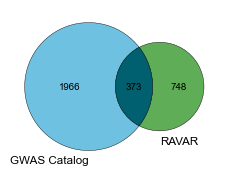

In [90]:
plt.rcParams.update({'font.size': 7})
_ = plt.figure(figsize=(3,2))
v = venn2(subsets=(cv_start-final_count, rv_start-final_count, final_count), set_labels=( 'GWAS Catalog','RAVAR'))
v.get_patch_by_id('10').set_color('#6ec1e0')
v.get_patch_by_id('01').set_color('#5fad56')
v.get_patch_by_id('11').set_color('#00606f')
for patch in ['01', '10', '11']:
    v.get_patch_by_id(patch).set_alpha(1)
    v.get_patch_by_id(patch).set_ec('black')
    v.get_patch_by_id(patch).set_lw(0.3)
plt.savefig(os.path.join(figdir, 'trait_overlap_venn2.svg'), dpi=400, bbox_inches='tight')

## Figure 1B - Domain Distribution

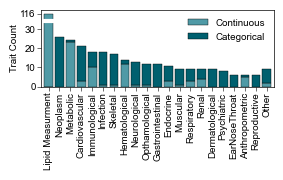

In [91]:
domains = final_shared_df.Domain.value_counts().reset_index()
domain_plot_values = domains[domains['count']>=5].Domain.values
domains = final_shared_df[final_shared_df.trait_type=='Q'].Domain.value_counts().reset_index()
domains_plot = domains[domains.Domain.isin(domain_plot_values)]
other=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict =domains_plot.set_index('Domain')['count'].to_dict()
domain_dict['Other'] = other

domains = final_shared_df[final_shared_df.trait_type=='CC'].Domain.value_counts().reset_index()
domains_plot2 = domains[domains.Domain.isin(domain_plot_values)]
other2=domains[~domains.Domain.isin(domain_plot_values)]['count'].sum()
domain_dict2 =domains_plot2.set_index('Domain')['count'].to_dict()
domain_dict2['Other'] = other2

_ = plt.figure(figsize=(3, 1))
plot_df = pd.DataFrame({'Continuous': domain_dict, 'Categorical': domain_dict2}).iloc[::-1]
plot_df['sum'] = np.nansum(plot_df, axis=1)
plot_df.at['Other', 'sum'] = 0
plot_df = plot_df.sort_values('sum', ascending=False)
lipid = plot_df.at['Lipid Measurment', 'Continuous']
plot_df.at['Lipid Measurment', 'Continuous'] = 38
plot_df.drop(columns='sum').plot(kind='bar', stacked=True, ax=plt.gca(),edgecolor='black', linewidth=0.3, width=0.8,
                                                                              color=[ '#509AA6', '#00606f',])


plt.hlines(y=34, xmin=-18.5, xmax=20.5,color='white', linewidth=3)
plt.ylim(0, 40)
plt.yticks([0, 10, 20, 30, 38], labels=[0,10,20,30,int(lipid)])
plt.ylabel('Trait Count')
plt.savefig(os.path.join(figdir, 'GCat_input_trait_types_vertical.svg'), bbox_inches='tight')

In [102]:
domain_dict

{'Lipid Measurment': 116,
 'Metabolic': 23,
 'Hematological': 12,
 'Immunological': 10,
 'Anthropometric': 5,
 'Renal': 4,
 'Cardiovascular': 3,
 'Endocrine': 3,
 'Respiratory': 3,
 'Neurological': 1,
 'Opthamological': 1,
 'Muscular': 1,
 'Skeletal': 1,
 'Infection': 1,
 'Other': 2}

In [108]:
print('Number of categorical traits:', int(plot_df.sum()['Categorical']))
print('\nTop categorical dommains:\n',pd.DataFrame({'Categorical':domain_dict2}).sort_values('Categorical', ascending=False).head(3))
print('\nTop continuous dommains:\n',pd.DataFrame({'Continuous':domain_dict}).sort_values('Continuous', ascending=False).head(3))

Number of categorical traits: 187

Top categorical dommains:
                 Categorical
Neoplasm                 26
Cardiovascular           18
Infection                17

Top continuous dommains:
                   Continuous
Lipid Measurment         116
Metabolic                 23
Hematological             12


## Figure 1D & E - Shared & disjoint genes

In [110]:

def get_common_genes(t, gwas_genes, accession, trait):
    study_genes = gwas_genes[(gwas_genes.TRAIT_CODE_CLEAN==t) & (gwas_genes['STUDY ACCESSION']==accession) & (gwas_genes['DISEASE/TRAIT']==trait)]
    study_genes = study_genes.sort_values('logp', ascending=False)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    return study_genes

def get_rare_genes(t, pmid, trait, ravar_gene):
    study_genes = ravar_genes[(ravar_genes.TRAIT_CODE_CLEAN==t) & (ravar_genes['PMID']==pmid) & (ravar_genes['Reported Trait']==trait)]
    study_genes = study_genes.sort_values('P-value', ascending=True)
    study_genes = study_genes.drop_duplicates(subset='Entrez')
    study_genes['logp'] = study_genes['P-value'].apply(lambda x: -1 * np.log10(x +1e-250))
    return study_genes

results = {}
n_overlaps = {}

for i, t in tqdm(enumerate(final_shared_df.TRAIT_CODE_CLEAN.values)):
    # get common genes
    accession = final_shared_df.iloc[i]['STUDY ACCESSION']
    trait = final_shared_df.iloc[i]['DISEASE/TRAIT']
    c_genes = get_common_genes(t, gwas_genes, accession, trait)
    pmid = final_shared_df.iloc[i]['PMID']
    trait = final_shared_df.iloc[i]['Reported Trait']
    r_genes = get_rare_genes(t, pmid, trait, ravar_genes )
    overlap_genes = set(c_genes.Entrez.values).intersection(set(r_genes.Entrez.values))
    n_overlaps[t] = len(overlap_genes)
    c_disjoint = c_genes[~c_genes.Entrez.isin(overlap_genes)]
    r_disjoint = r_genes[~r_genes.Entrez.isin(overlap_genes)]
    if len(overlap_genes) > 0:
    # common
        if len(c_disjoint) > 0:
            cDisjoint = c_disjoint.logp.median()
            cShared = c_genes[c_genes.Entrez.isin(overlap_genes)].logp.median()
        else:
            cDisjoint = np.nan
            cShared = np.nan
    
    # rare
        if len(r_disjoint) > 0:
            rDisjoint = r_disjoint.logp.median()
            rShared = r_genes[r_genes.Entrez.isin(overlap_genes)].logp.median()
        else:
            rDisjoint = np.nan
            rShared = np.nan
    else:
        cDisjoint = np.nan
        cShared = np.nan
        rDisjoint = np.nan
        rShared = np.nan
    results[t] = {'rSharedMed': rShared, 'cSharedMed': cShared, 'rOnlyMed':rDisjoint, 'cOnlyMed': cDisjoint}

373it [00:25, 14.35it/s]


In [118]:
over_df = final_shared_df.loc[:, ('TRAIT_CODE_CLEAN', 'trait_type')].set_index('TRAIT_CODE_CLEAN').join(pd.DataFrame({'Shared':n_overlaps}))
counts_q={}
counts_cc = {}
for lo,hi in [(0,0), (1,2), (3, 4), (5,6), (7,8), (9,10), (11,40)]:
    c_df = over_df[over_df.trait_type=='CC']
    q_df = over_df[over_df.trait_type=='Q']
    counts_cc[f'{lo}-{hi}'] = c_df[(c_df.Shared >= lo) & (c_df.Shared<=hi)].shape[0]
    counts_q[f'{lo}-{hi}'] = q_df[(q_df.Shared >= lo) & (q_df.Shared<=hi)].shape[0]

### Figure 1D

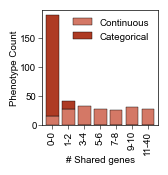

In [119]:
_ = plt.figure(figsize=(1.5,1.5))
ax=plt.gca()
pd.DataFrame({'Continuous':counts_q, 'Categorical':counts_cc}).plot(kind='bar', stacked=True, edgecolor='black', linewidth=0.3, width=0.8,
                                                                             ax=ax, color=[ '#D47866', '#AE3B24',])
ax.set_ylabel('Phenotype Count')
ax.set_xlabel('# Shared genes')
plt.savefig(os.path.join(figdir, 'shared_gene_counts.svg'), bbox_inches='tight')

### Figure 1E

In [121]:
test_df = pd.DataFrame.from_dict(results, orient='index')

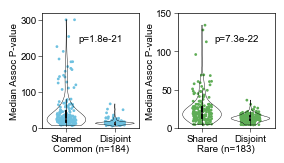

In [124]:
_, [ax1, ax2] = plt.subplots( nrows=1, ncols=2, figsize=(3, 1.5), gridspec_kw={'wspace':0.4})
sns.violinplot(test_df.melt(value_vars=[ 'cSharedMed', 'cOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', cut=0, fill=False, palette=['k','k'], linewidth=0.3,
              order = [ 'cSharedMed', 'cOnlyMed',], zorder=2, ax=ax1)
sns.stripplot(test_df.dropna().melt(value_vars=[ 'cSharedMed', 'cOnlyMed'], 
                                    var_name='Set', value_name='MedP'), palette=[blue, blue],
              order= [ 'cSharedMed', 'cOnlyMed'],jitter=0.2,
              x='Set', y='MedP', hue='Set', edgecolor='black', s=2, zorder=1, ax=ax1)

sns.violinplot(test_df.melt(value_vars=['rSharedMed', 'rOnlyMed'], var_name='Set', value_name='MedP'),
              x='Set', y='MedP', hue='Set', cut=0, fill=False, palette=['k', 'k'], linewidth=0.3,
              order = [ 'rSharedMed', 'rOnlyMed'], zorder=2, ax=ax2)
sns.stripplot(test_df.dropna().melt(value_vars=[ 'rSharedMed', 'rOnlyMed'], 
                                    var_name='Set', value_name='MedP'), palette=[ green, green],
              order= [ 'rSharedMed', 'rOnlyMed'],jitter=0.2,
              x='Set', y='MedP', hue='Set', edgecolor='black', s=2, zorder=1, ax=ax2)

common_df = test_df.loc[:, ('cSharedMed', 'cOnlyMed')].dropna()
rare_df = test_df.loc[:, ('rSharedMed', 'rOnlyMed')].dropna()

p_common = wilcoxon(common_df.cSharedMed, common_df.cOnlyMed).pvalue
p_rare = wilcoxon(rare_df.rSharedMed, rare_df.rOnlyMed).pvalue


for i, ax in enumerate([ax1, ax2]):
    ax.set_xticks([0,1], labels=['Shared', 'Disjoint'])
    ax.set_xlabel(f'{["Common", "Rare"][i]} (n={[len(common_df), len(rare_df)][i]})')
    ax.set_ylim(0, [320, 150][i])
    ax.text(x=0.25, y=[320, 150][i]*0.75, s=f'p={[p_common, p_rare][i]:.1e}')
    ax.set_ylabel('Median Assoc P-value')
plt.savefig(os.path.join(figdir, 'p_value_comparison.svg'),bbox_inches='tight')